# Import Library

In [41]:
!pip install keras_tuner

In [42]:
import os
import shutil
import holidays
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from google.colab import drive

# Library Statistik untuk EDA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Preprocessing & Metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

# Deep Learning (TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Tuning
import keras_tuner as kt

print("Library berhasil diimpor.")

Library berhasil diimpor.


# Data Preparation

## Load Data

In [43]:
drive.mount('/content/drive')

base_path = '/content/drive/MyDrive/Magang Prima PTKI/data_dummy'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
# Load Data
transactions_df = pd.read_csv(os.path.join(base_path, 'transactions.csv'))
transaction_details_df = pd.read_csv(os.path.join(base_path, 'transaction_details.csv'))
products_df = pd.read_csv(os.path.join(base_path, 'products.csv'))
stores_df = pd.read_csv(os.path.join(base_path, 'stores.csv'))

## Merging Data

In [45]:
# Merging
df_merged = pd.merge(transactions_df, transaction_details_df, left_on='id', right_on='transactionId')
df_merged = pd.merge(df_merged, products_df[['id', 'productCategoryId']], left_on='productId', right_on='id', suffixes=('', '_prod'))
df_merged = pd.merge(df_merged, stores_df[['id', 'storeTypeId']], left_on='storeId', right_on='id', suffixes=('', '_store'))

In [46]:
# 3. Filter Toko Peralatan Bayi (ID 9)
TARGET_STORE_ID = 9
df_baby = df_merged[df_merged['storeId'] == TARGET_STORE_ID].copy()
df_baby['transactionDate'] = pd.to_datetime(df_baby['transactionDate'])

## Data Cleaning

In [47]:
# 4. Agregasi Harian
time_series_baby = df_baby.groupby(df_baby['transactionDate'].dt.date)['subtotal'].sum().reset_index()
time_series_baby.columns = ['date', 'revenue']
time_series_baby['date'] = pd.to_datetime(time_series_baby['date'])
time_series_baby.set_index('date', inplace=True)

In [48]:
# 5. Reindex & Cleaning
all_days = pd.date_range(start=time_series_baby.index.min(), end=time_series_baby.index.max(), freq='D')
time_series_baby = time_series_baby.reindex(all_days, fill_value=0)

In [49]:
# 5. Cleaning Outliers (Clipping agar pola musiman/weekend tidak hilang)
Q1, Q3 = time_series_baby['revenue'].quantile([0.25, 0.75])
IQR = Q3 - Q1
time_series_baby['revenue_clean'] = time_series_baby['revenue'].clip(lower=Q1 - 1.5*IQR, upper=Q3 + 1.5*IQR)

print(f"Data Peralatan Bayi (ID {TARGET_STORE_ID}) Berhasil Disiapkan.")

Data Peralatan Bayi (ID 9) Berhasil Disiapkan.


# Exploratory Data Analysis (EDA)

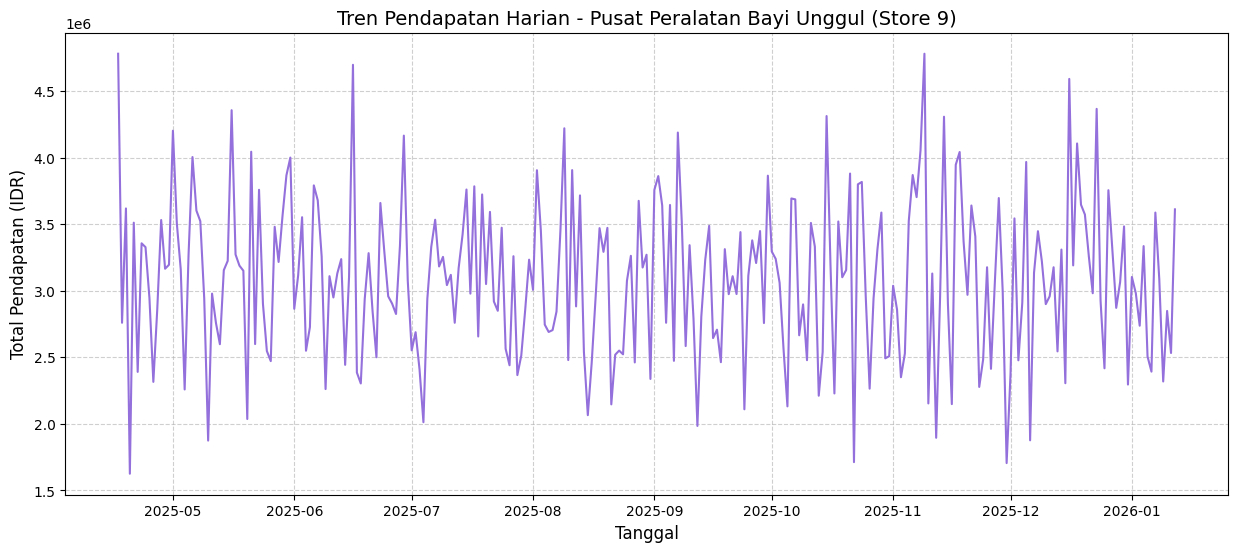

In [50]:
# 1. Tren Pendapatan Harian
# Memvisualisasikan fluktuasi pendapatan dari waktu ke waktu untuk melihat tren pertumbuhan atau penurunan.
plt.figure(figsize=(15, 6))
plt.plot(time_series_baby.index, time_series_baby['revenue_clean'], color='mediumpurple', linewidth=1.5)
plt.title(f'Tren Pendapatan Harian - Pusat Peralatan Bayi Unggul (Store 9)', fontsize=14)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Total Pendapatan (IDR)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

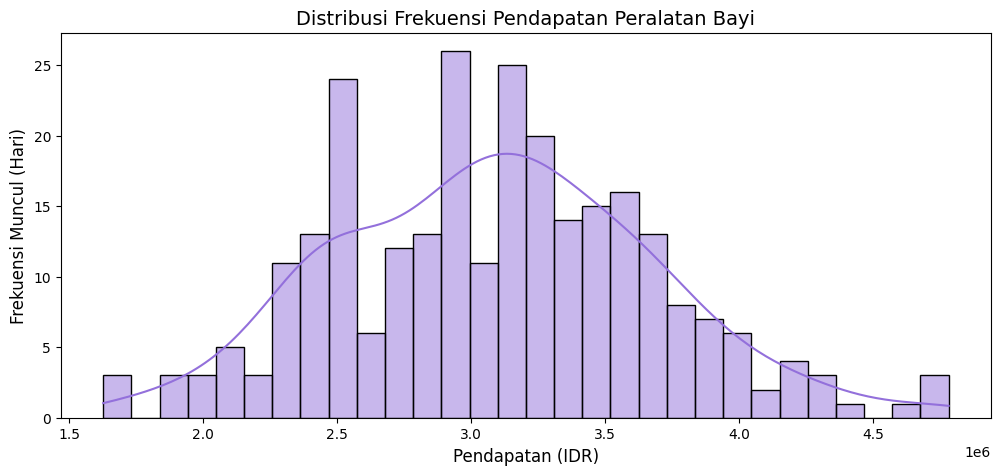

In [51]:
# 2. Distribusi Pendapatan (Histogram & KDE)
# Melihat apakah persebaran data pendapatan cenderung normal atau memiliki banyak outlier.
plt.figure(figsize=(12, 5))
sns.histplot(time_series_baby['revenue_clean'], kde=True, color='mediumpurple', bins=30)
plt.title('Distribusi Frekuensi Pendapatan Peralatan Bayi', fontsize=14)
plt.xlabel('Pendapatan (IDR)', fontsize=12)
plt.ylabel('Frekuensi Muncul (Hari)', fontsize=12)
plt.show()

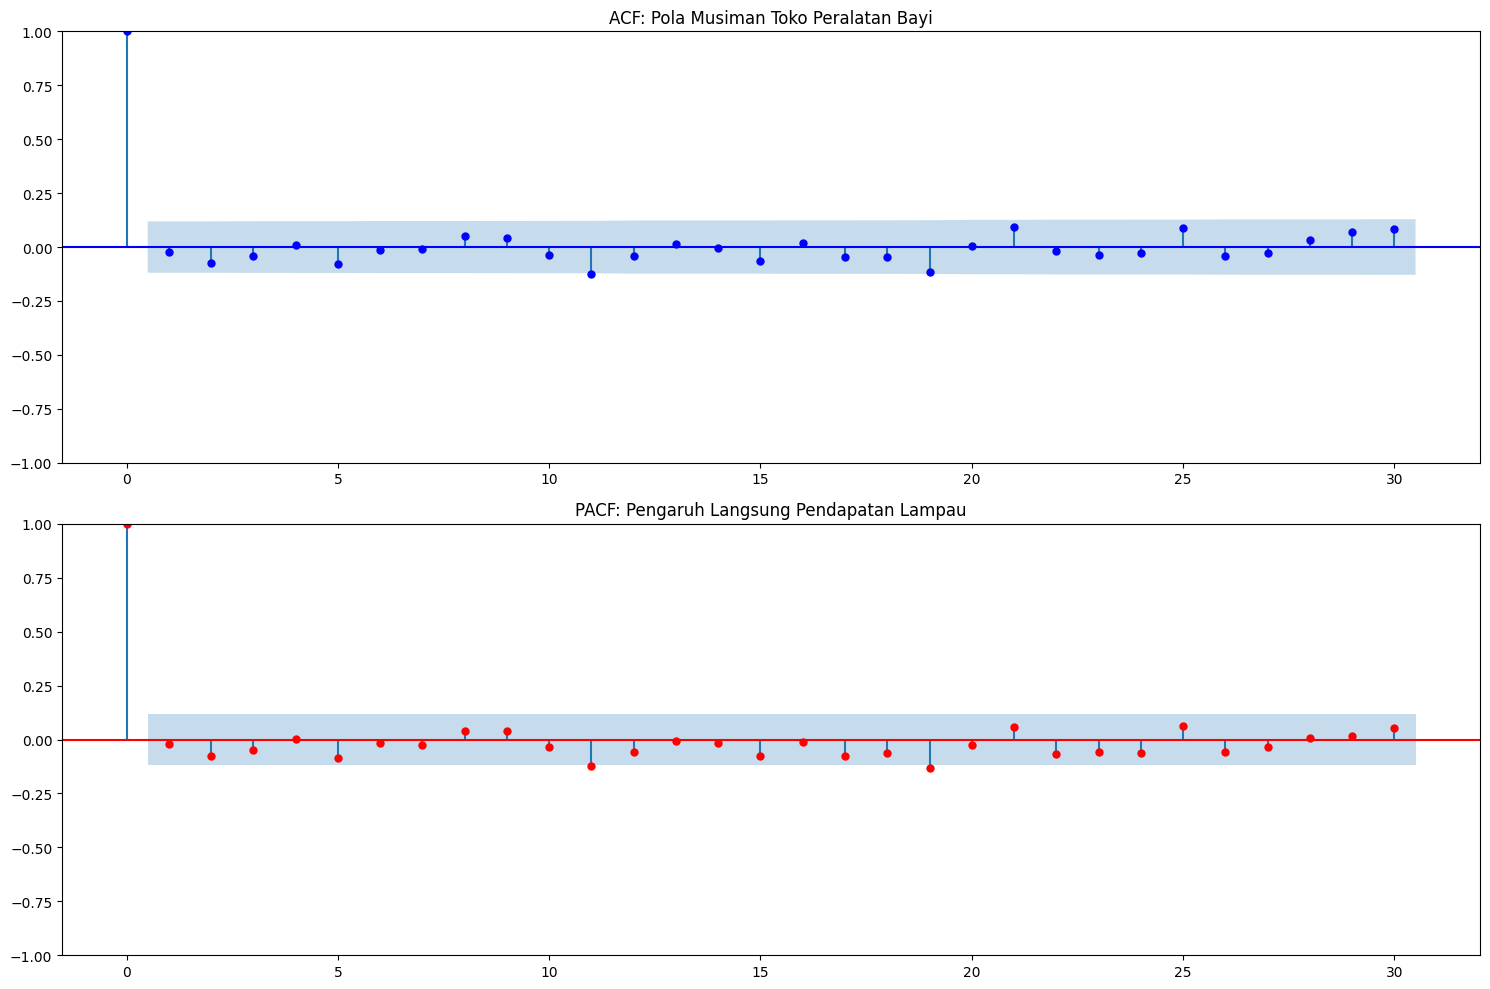

In [52]:
# 3. Autocorrelation (ACF) & Partial Autocorrelation (PACF)
# Digunakan untuk mengonfirmasi hubungan antara pendapatan hari ini dengan hari-hari sebelumnya (Lag).
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
plot_acf(time_series_baby['revenue_clean'], lags=30, ax=ax1, color='blue')
ax1.set_title('ACF: Pola Musiman Toko Peralatan Bayi', fontsize=12)
plot_pacf(time_series_baby['revenue_clean'], lags=30, ax=ax2, color='red')
ax2.set_title('PACF: Pengaruh Langsung Pendapatan Lampau', fontsize=12)
plt.tight_layout()
plt.show()

/tmp/ipython-input-3361003722.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='day_name', y='revenue_clean', data=time_series_baby, order=order, palette='BuPu')


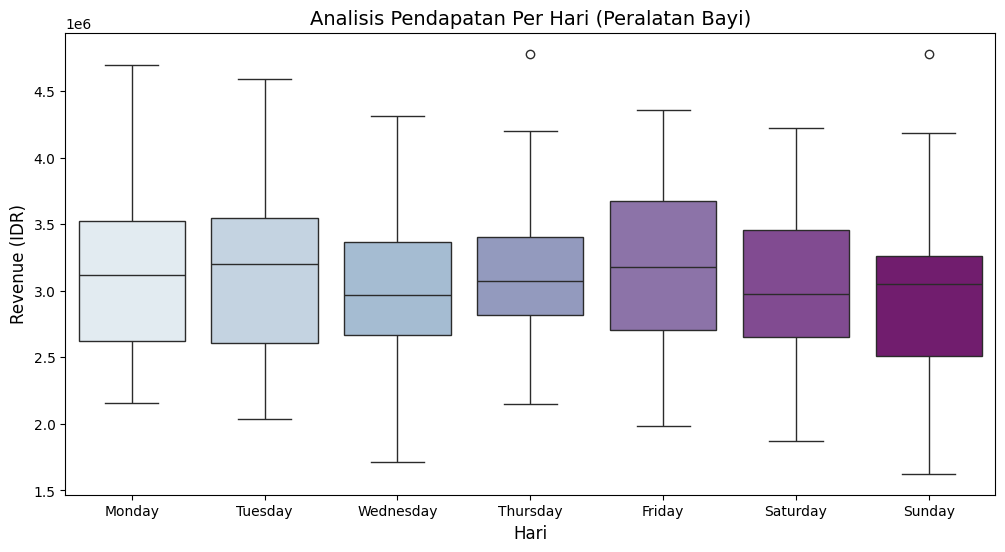

In [53]:
# 4. Boxplot Hari dalam Seminggu (Analisis Peak Time)
# Menentukan hari apa saja yang menjadi puncak penjualan (biasanya weekend atau awal minggu).
time_series_baby['day_name'] = time_series_baby.index.day_name()
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(12, 6))
sns.boxplot(x='day_name', y='revenue_clean', data=time_series_baby, order=order, palette='BuPu')
plt.title('Analisis Pendapatan Per Hari (Peralatan Bayi)', fontsize=14)
plt.ylabel('Revenue (IDR)', fontsize=12)
plt.xlabel('Hari', fontsize=12)
plt.show()

In [54]:
# 5. Ringkasan Statistik dengan Format Rupiah
# Memberikan gambaran angka pasti mengenai performa rata-rata harian toko.
stats = time_series_baby['revenue_clean'].describe()
print("\n" + "="*45)
print("   RINGKASAN STATISTIK PENDAPATAN PERALATAN BAYI")
print("="*45)
print(f"Jumlah Data (Hari)  : {stats['count']:,.0f}")
print(f"Rata-rata Harian    : Rp {stats['mean']:,.2f}")
print(f"Standar Deviasi     : Rp {stats['std']:,.2f}")
print(f"Pendapatan Minimum  : Rp {stats['min']:,.2f}")
print(f"Median (P50)        : Rp {stats['50%']:,.2f}")
print(f"Pendapatan Maksimum : Rp {stats['max']:,.2f}")
print("="*45)


   RINGKASAN STATISTIK PENDAPATAN PERALATAN BAYI
Jumlah Data (Hari)  : 271
Rata-rata Harian    : Rp 3,087,832.10
Standar Deviasi     : Rp 591,146.61
Pendapatan Minimum  : Rp 1,626,000.00
Median (P50)        : Rp 3,106,000.00
Pendapatan Maksimum : Rp 4,781,250.00


# Preprocessing Data

## Feature Engineering

(Menambah Konteks Waktu)

In [55]:
# 1. Feature Engineering (Konteks Waktu & Hari Libur)
id_holidays = holidays.Indonesia(years=[2025, 2026])
time_series_baby['is_holiday'] = time_series_baby.index.strftime('%Y-%m-%d').isin(id_holidays).astype(int)
time_series_baby['is_payday'] = time_series_baby.index.day.map(lambda x: 1 if x >= 25 or x <= 5 else 0)
time_series_baby['is_weekend'] = time_series_baby.index.weekday.map(lambda x: 1 if x >= 5 else 0)

In [56]:
# Fitur Lag 1-7
for i in range(1, 8):
    time_series_baby[f'lag_{i}'] = time_series_baby['revenue_clean'].shift(i)

In [57]:
# Fitur Tren (Rolling Average 7 hari)
time_series_baby['rolling_avg_7d'] = time_series_baby['revenue_clean'].rolling(window=7).mean()

In [58]:
# Update Feature Engineering (Menambah Day of Month)
time_series_baby['day_of_month'] = time_series_baby.index.day

In [59]:
# Hapus baris yang kosong akibat proses Lag
time_series_baby.dropna(inplace=True)

## Scaling

In [60]:
# Definisikan Input (X) dan Target (y)
# Kita menggunakan 11 fitur: Lag (1-7), is_holiday, is_payday, is_weekend, dan rolling_avg_7d
features = [f'lag_{i}' for i in range(1, 8)] + ['is_holiday', 'is_payday', 'is_weekend', 'rolling_avg_7d', 'day_of_month']
X_raw = time_series_baby[features]
y_raw = time_series_baby['revenue_clean']

print(f"Feature Engineering Selesai. Total Fitur: {len(features)}")

Feature Engineering Selesai. Total Fitur: 12


In [61]:
# 3. Scaling (Mengubah angka jutaan ke skala 0-1)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

In [62]:
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw.values.reshape(-1, 1))

In [63]:
# 4. Reshaping ke format 3D untuk LSTM [Samples, Time Steps, Features]
X_final = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
y_final = y_scaled

## Splitting Data (Train & Test)

In [64]:
# 5. Split Data (80% Training, 20% Testing)
train_size = int(len(X_final) * 0.8)
X_train, X_test = X_final[:train_size], X_final[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

print(f"Preprocessing Peralatan Bayi Selesai. Train size: {len(X_train)} hari.")

Preprocessing Peralatan Bayi Selesai. Train size: 211 hari.


# Modeling

In [65]:
def model_builder(hp):
    model = Sequential()

    # CNN Layer
    model.add(Conv1D(
        filters=hp.Int("conv_filters", 32, 128, 16),
        kernel_size=1, activation='relu',
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(MaxPooling1D(pool_size=1))

    # Bi-LSTM Layer
    model.add(Bidirectional(LSTM(units=hp.Int("bilstm_units", 64, 256, 32), return_sequences=True)))
    model.add(Dropout(hp.Float("dropout_1", 0.1, 0.4, 0.1)))

    # LSTM 2
    model.add(LSTM(units=hp.Int("lstm_units", 32, 128, 32), return_sequences=False))

    model.add(Dense(hp.Int("dense_units", 32, 128, 32), activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Reset Tuner Khusus Baby & Kids
tuner_path = 'tuner_dir/baby_tuning'
if os.path.exists(tuner_path):
    shutil.rmtree(tuner_path)

tuner = kt.RandomSearch(
    model_builder, objective='val_loss', max_trials=10,
    directory='tuner_dir', project_name='baby_tuning', overwrite=True
)

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

print("Memulai Hyperparameter Tuning untuk Peralatan Bayi...")
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stop])

# Ambil Model Terbaik
best_model = tuner.get_best_models(num_models=1)[0]
print("\nTuning Selesai. Arsitektur model terbaik dipilih.")
best_model.summary()

Trial 10 Complete [00h 00m 25s]
val_loss: 0.034205514937639236

Best val_loss So Far: 0.02268214337527752
Total elapsed time: 00h 03m 59s

Tuning Selesai. Arsitektur model terbaik dipilih.


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 112)         │         1,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 112)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 1, 256)         │       246,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 287,409 (1.10 MB)

 Trainable params: 287,409 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

# Evaluation & Visualization

In [66]:
# 1. Pelatihan Akhir Model Terbaik
print("Melatih model akhir...")
history = best_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Melatih model akhir...
Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 0.0116 - mae: 0.0869 - val_loss: 0.0241 - val_mae: 0.1276
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0090 - mae: 0.0791 - val_loss: 0.0233 - val_mae: 0.1254
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0066 - mae: 0.0644 - val_loss: 0.0236 - val_mae: 0.1243
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0091 - mae: 0.0756 - val_loss: 0.0222 - val_mae: 0.1189
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0092 - mae: 0.0749 - val_loss: 0.0209 - val_mae: 0.1174
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0066 - mae: 0.0633 - val_loss: 0.0200 - val_mae: 0.1171
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0058 - mae: 0.0557 - val_loss: 0.0188 - val_mae: 0.1127
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0047 - mae: 0.0515 - val_loss: 0.0173 - val_mae: 0.1076
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━

In [67]:
# 2. Prediksi & Kembalikan Skala (Inverse Transform)
y_pred_scaled = best_model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 489ms/step


In [68]:
# 3. Inverse Scale (Kembalikan ke nilai Rupiah asli)
y_pred = scaler_y.inverse_transform(y_pred_scaled).ravel()
y_actual = scaler_y.inverse_transform(y_test).ravel()

In [69]:
# 4. Hitung Metrik Utama
mae = mean_absolute_error(y_actual, y_pred)
mape = mean_absolute_percentage_error(y_actual, y_pred) * 100
r2 = r2_score(y_actual, y_pred)

In [70]:
print("="*50)
print("     HASIL AKHIR - TOKO RUMAH TANGGA (STORE 5)")
print("="*50)
print(f"1. Mean Absolute Error (MAE)  : Rp {mae:,.2f}")
print(f"2. MAPE (Tingkat Error)       : {mape:.2f}%")
print(f"3. R2-Score (Akurasi Model)   : {r2:.4f}")
print("="*50)

     HASIL AKHIR - TOKO RUMAH TANGGA (STORE 5)
1. Mean Absolute Error (MAE)  : Rp 140,174.72
2. MAPE (Tingkat Error)       : 4.92%
3. R2-Score (Akurasi Model)   : 0.9065


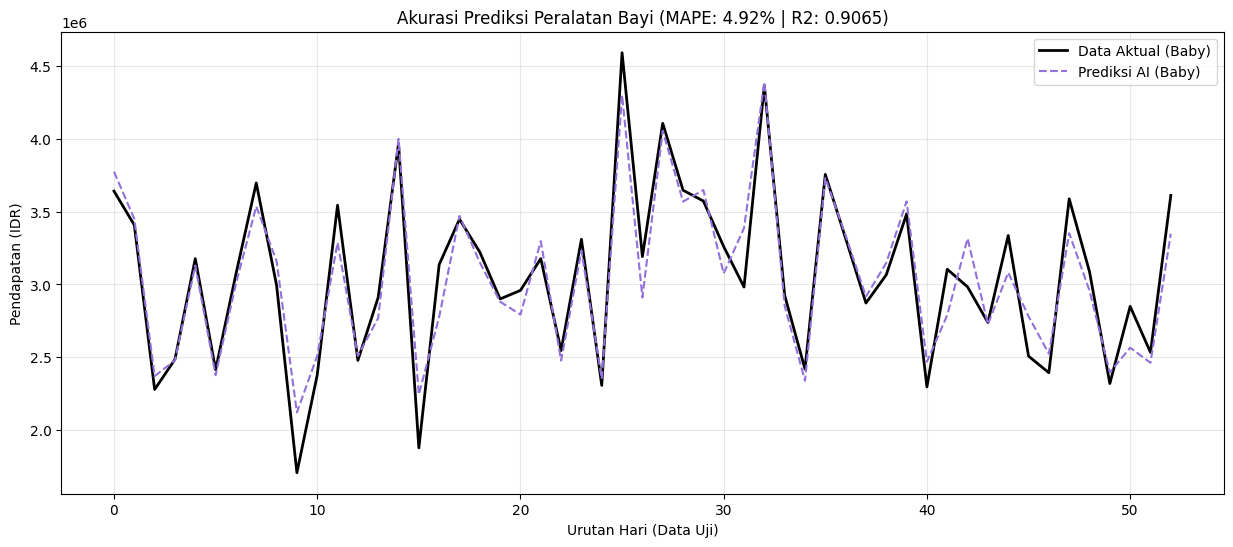

In [71]:
# 5. Visualisasi 1: Prediksi vs Aktual
plt.figure(figsize=(15, 6))
plt.plot(y_actual, label='Data Aktual (Baby)', color='black', linewidth=2)
plt.plot(y_pred, label='Prediksi AI (Baby)', color='mediumpurple', linestyle='--')
plt.title(f'Akurasi Prediksi Peralatan Bayi (MAPE: {mape:.2f}% | R2: {r2:.4f})')
plt.ylabel('Pendapatan (IDR)')
plt.xlabel('Urutan Hari (Data Uji)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

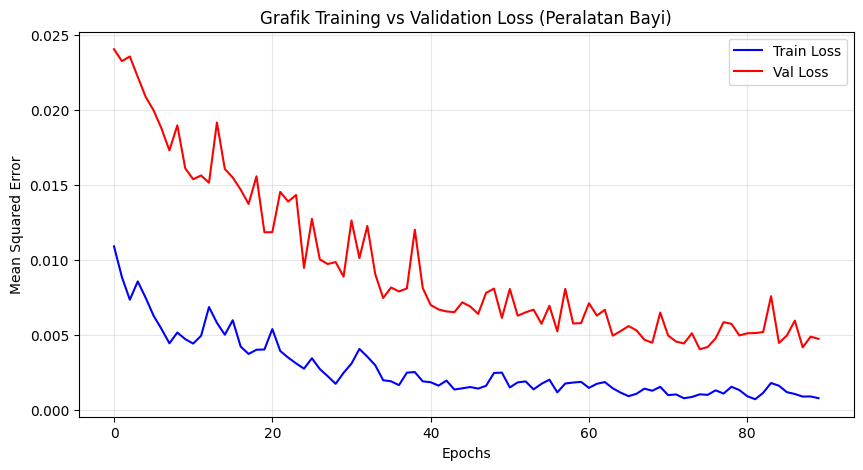

In [72]:
# 6. Visualisasi 2: Grafik Training vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='red')
plt.title('Grafik Training vs Validation Loss (Peralatan Bayi)')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Save Model

In [73]:
# Simpan Model & Scaler Peralatan Bayi
model_path = '/content/drive/MyDrive/Magang Prima PTKI/models/peralatan_bayi/model_baby_store_9.keras'
os.makedirs(os.path.dirname(model_path), exist_ok=True)

# Simpan Model dalam format .keras
best_model.save(model_path)

# Simpan Scaler X dan Y menggunakan joblib
joblib.dump(scaler_X, '/content/drive/MyDrive/Magang Prima PTKI/models/peralatan_bayi/scaler_X_baby.pkl')
joblib.dump(scaler_y, '/content/drive/MyDrive/Magang Prima PTKI/models/peralatan_bayi/scaler_y_baby.pkl')

['/content/drive/MyDrive/Magang Prima PTKI/models/peralatan_bayi/scaler_y_baby.pkl']

# Kode Inference Dengan Analisis Bisnis

In [74]:
# 1. Load Model & Scaler
model = load_model('/content/drive/MyDrive/Magang Prima PTKI/models/peralatan_bayi/model_baby_store_9.keras')
scaler_X = joblib.load('/content/drive/MyDrive/Magang Prima PTKI/models/peralatan_bayi/scaler_X_baby.pkl')
scaler_y = joblib.load('/content/drive/MyDrive/Magang Prima PTKI/models/peralatan_bayi/scaler_y_baby.pkl')

In [75]:
def get_forecast_7_days_stabilized_baby(model, df_historical, scaler_X, scaler_y):
    # Ambil data 7 hari terakhir
    current_lags = df_historical['revenue_clean'].tail(7).tolist()

    # Hitung rata-rata per hari dalam seminggu (untuk Rem/Stabilizer)
    weekly_pattern = df_historical.groupby(df_historical.index.dayofweek)['revenue_clean'].mean()

    predictions = []
    dates = []
    last_date = df_historical.index[-1]
    id_holidays = holidays.Indonesia(years=[last_date.year, last_date.year + 1])

    print("="*60)
    print(f"   PREDIKSI OPERASIONAL BABY & KIDS TERSTABILISASI (7 HARI)")
    print(f"   (Batas Data: {last_date.strftime('%d %b %Y')})")
    print("="*60)

    for i in range(1, 8):
        current_date = last_date + timedelta(days=i)
        day_idx = current_date.weekday()

        # Fitur Engineering
        is_holiday = 1 if current_date.strftime('%Y-%m-%d') in id_holidays else 0
        is_payday = 1 if current_date.day >= 25 or current_date.day <= 5 else 0
        is_weekend = 1 if day_idx >= 5 else 0
        rolling_avg = np.mean(current_lags)
        day_of_month = current_date.day

        # Susun fitur (12 fitur)
        input_row = current_lags + [is_holiday, is_payday, is_weekend, rolling_avg, day_of_month]

        # Scaling & Prediksi
        input_scaled = scaler_X.transform([input_row])
        input_final = input_scaled.reshape((1, 1, len(features)))
        pred_scaled = model.predict(input_final, verbose=0)
        raw_pred = scaler_y.inverse_transform(pred_scaled)[0][0]

        # --- LOGIKA "REM" (STABILIZER) ---
        avg_hist_day = weekly_pattern[day_idx]
        stabilized_pred = (raw_pred * 0.7) + (avg_hist_day * 0.3)

        # Clipping: Mencegah prediksi melompat tidak wajar
        max_limit = df_historical['revenue_clean'].max() * 1.2
        final_pred = min(stabilized_pred, max_limit)

        predictions.append(final_pred)
        dates.append(current_date)

        # Update Lags untuk iterasi berikutnya
        current_lags.pop(0)
        current_lags.append(final_pred)

        # Status berdasarkan statistik deskriptif data Baby & Kids
        status = "RAMAI" if final_pred > stats['mean'] * 1.1 else "NORMAL"
        print(f"{current_date.strftime('%A, %d %b')}: Rp {final_pred:,.0f} | {status}")

    return pd.DataFrame({'date': dates, 'pred_revenue': predictions}).set_index('date')

In [76]:
# Jalankan Proyeksi Baru untuk Baby & Kids
forecast_results_stable_baby = get_forecast_7_days_stabilized_baby(best_model, time_series_baby, scaler_X, scaler_y)

   PREDIKSI OPERASIONAL BABY & KIDS TERSTABILISASI (7 HARI)
   (Batas Data: 12 Jan 2026)
Tuesday, 13 Jan: Rp 3,427,394 | RAMAI
Wednesday, 14 Jan: Rp 3,263,756 | NORMAL


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Thursday, 15 Jan: Rp 3,081,433 | NORMAL
Friday, 16 Jan: Rp 2,440,399 | NORMAL
Saturday, 17 Jan: Rp 2,585,675 | NORMAL


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Sunday, 18 Jan: Rp 2,605,292 | NORMAL
Monday, 19 Jan: Rp 2,745,585 | NORMAL


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


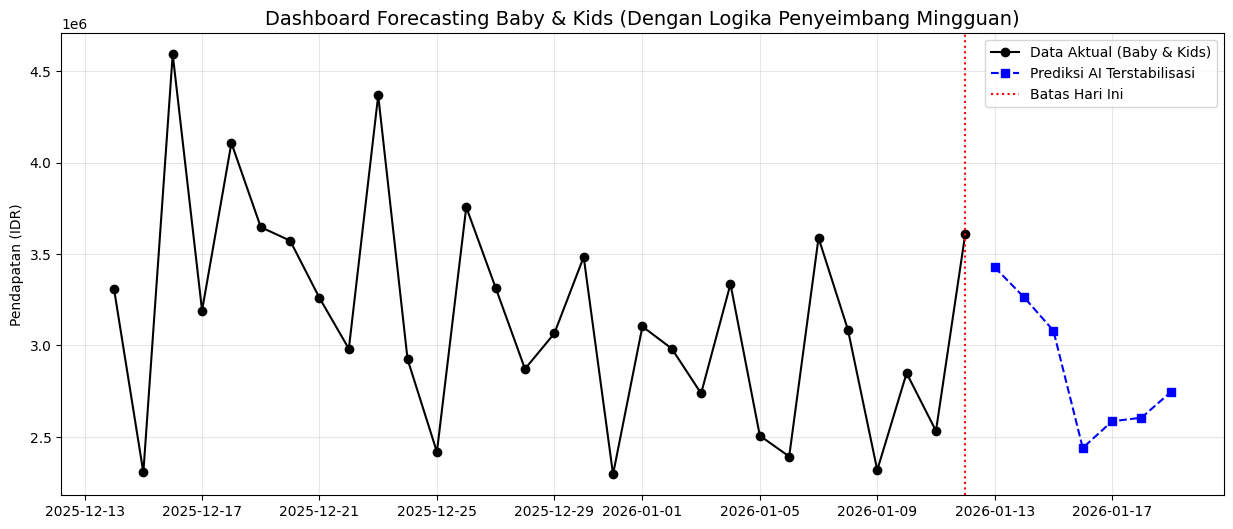

In [77]:
# Visualisasi
plt.figure(figsize=(15, 6))
hist_data_baby = time_series_baby.tail(30)

plt.plot(hist_data_baby.index, hist_data_baby['revenue_clean'],
         label='Data Aktual (Baby & Kids)', color='black', marker='o')

plt.plot(forecast_results_stable_baby.index, forecast_results_stable_baby['pred_revenue'],
         label='Prediksi AI Terstabilisasi', color='blue', linestyle='--', marker='s')

plt.axvline(x=hist_data_baby.index[-1], color='red', linestyle=':', label='Batas Hari Ini')
plt.title('Dashboard Forecasting Baby & Kids (Dengan Logika Penyeimbang Mingguan)', fontsize=14)
plt.ylabel('Pendapatan (IDR)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()